<모듈 불러오기>

In [1]:
!echo 'Current working directory:' $PWD
!ls -al

Current working directory: /content
total 40
drwxr-xr-x 1 root root  4096 Jul 30 04:29 .
drwxr-xr-x 1 root root  4096 Jul 30 04:29 ..
drwxr-xr-x 1 root root  4096 Jul 19 16:14 .config
-rw-r--r-- 1 root root 23348 Jul 30 04:29 layer_vis_l2_f5.jpg
drwxr-xr-x 1 root root  4096 Jul 19 16:14 sample_data


In [10]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [11]:
!ls -al '/content/gdrive/My Drive/Colab Notebooks'

total 209
-rw------- 1 root root  10340 Jul 30 02:47 CNN_vision.ipynb
-rw------- 1 root root 140391 Jul 29 05:45 cute.jpg
-rw------- 1 root root  16254 Jul 30 04:53 gradCAM.ipynb
-rw------- 1 root root  35363 Jul 29 05:45 imagenet_class_index.json
-rw------- 1 root root   9609 Jul 30 04:30 viz_filter.ipynb


In [0]:
import cv2
import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


<GPU 확인>

In [0]:
device = torch.device('cuda')

<VGG 모델 정의>

In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = vgg16(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation extraction
    def get_activations(self, x):
        return self.features_conv(x)

<모델 선언>

In [7]:
# initialize the VGG model
vgg = VGG().to(device)

# set the evaluation mode
vgg.eval()

VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, paddin

<이미지 불러오기>

In [0]:
img = Image.open("/content/gdrive/My Drive/Colab Notebooks/cute.jpg")
img = np.asarray(img)
img = cv2.resize(img, (224, 224))
img = img.transpose([2, 0, 1])
img = img.astype('float32')
img /= 255.


<이미지 모델에 전달하기 (예측)>

In [17]:
img.shape

(3, 224, 224)

In [18]:
img = np.expand_dims(img, 0)
img = torch.tensor(img).to(device)
pred = vgg(img)
pred.argmax(dim=1)

tensor([285], device='cuda:0')

<Imagenet 데이터 클래스명 확인>

In [20]:
predicted = pred.cpu().detach().numpy()[0]
candidate = predicted.argsort()[-5:][::-1]

import json
class_idx = json.load(open("/content/gdrive/My Drive/Colab Notebooks/imagenet_class_index.json"))
class_idx['285']

for c in candidate:
    print(class_idx[str(c)])

['n02124075', 'Egyptian_cat']
['n02127052', 'lynx']
['n02123045', 'tabby']
['n02123597', 'Siamese_cat']
['n02123159', 'tiger_cat']


<grad-CAM 코드>

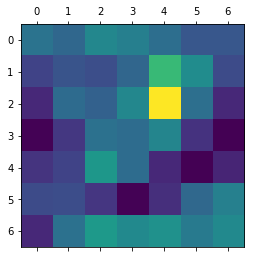

In [21]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 285].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.to('cpu'), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

<히트맵 그리기>

In [22]:
img = Image.open("/content/gdrive/My Drive/Colab Notebooks/cute.jpg")
img = np.asarray(img)
img = cv2.resize(img, (224, 224))

heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('map.jpg', superimposed_img)

True